In [ ]:
import os
import json
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

# Ruta a las imágenes y etiquetas
img_dir = r'C:\CatFLW dataset\images'
labels_dir = r'C:\CatFLW dataset\labels'
output_dir = r'C:\CatFLW dataset\cropped_images'  # Ruta para guardar los recortes

# Crear el directorio de salida si no existe
os.makedirs(output_dir, exist_ok=True)

# Dataset personalizado para cargar imágenes y etiquetas
class CatFaceDataset(Dataset):
    def __init__(self, img_dir, labels_dir, transform=None):
        self.img_dir = img_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(self.labels_dir, img_name.replace('.png', '.json'))
        
        # Cargar imagen
        image = np.array(Image.open(img_path).convert('RGB'))
        
        # Cargar etiquetas
        with open(label_path, 'r') as f:
            labels = json.load(f)
            bounding_box = labels['bounding_boxes']  # Coordenadas de la caja delimitadora

        # Aplicar las transformaciones de imagen y bounding box
        if self.transform:
            augmented = self.transform(image=image, bboxes=[bounding_box])
            image = augmented['image']
            bounding_box = augmented['bboxes'][0]  # Actualizar el bounding box
        
        return image, torch.tensor(bounding_box).float(), img_name  # Devuelve también el nombre del archivo

# Aumentaciones para el conjunto de entrenamiento utilizando albumentations
augmentation_transforms = A.Compose([
    
    A.Rotate(limit=30, p=0.5),  # Rotación aleatoria con 50% de probabilidad
    A.ColorJitter(p=0.5),  # Cambio en el balance de color, brillo, contraste y nitidez con 50% de probabilidad
    A.RandomBrightnessContrast(p=0.5),  # Cambio en  el brillo y contraste con 50% de probabilidad
    A.GaussianBlur(p=0.1),  # Aplicación de máscaras de desenfoque con 50% de probabilidad
    A.GaussNoise(p=0.1),  # Ruido aleatorio con 50% de probabilidad
    A.Resize(224, 224),  # Redimensionar a 224x224
    A.Normalize(),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=[]))

# Transformación básica (sin aumento) para validación
basic_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=[]))

# Dataset con aumentaciones aplicadas solo en el conjunto de entrenamiento
class AugmentedCatFaceDataset(Dataset):
    def __init__(self, img_dir, labels_dir, transform=None, augment_transform=None):
        self.dataset = CatFaceDataset(img_dir, labels_dir, transform)
        self.augment_transform = augment_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, bounding_box, img_name = self.dataset[idx]

        # Asegúrate de que la imagen esté en formato numpy array antes de pasarla a Albumentations
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).cpu().numpy()  # Convertir de tensor a numpy array si es necesario

        # Aplicar las transformaciones de aumento
        if random.random() < 0.5:
            augmented = self.augment_transform(image=image, bboxes=[bounding_box])
            image = augmented['image']
            bounding_box = augmented['bboxes'][0]

        # Asegúrate de que la imagen esté en formato [3, 224, 224] antes de devolverla
        if isinstance(image, np.ndarray):
            image = torch.tensor(image).permute(2, 0, 1)  # Convertir de numpy a tensor y reorganizar dimensiones

        return image, torch.tensor(bounding_box).float(), img_name

# Función de colación personalizada para asegurarse de que los bounding boxes sean tensors
def custom_collate_fn(batch):
    images, bounding_boxes, img_names = zip(*batch)
    
    # Convierte las imágenes a tensores
    images = torch.stack([img for img in images])
    
    # Convierte las bounding boxes a tensores
    bounding_boxes = torch.stack([torch.tensor(bbox, dtype=torch.float32) for bbox in bounding_boxes])
    
    return images, bounding_boxes, img_names

# Crear el dataset con aumento en el conjunto de entrenamiento
augmented_dataset = AugmentedCatFaceDataset(img_dir, labels_dir, transform=basic_transform, augment_transform=augmentation_transforms)

# Dividir el dataset en entrenamiento y validación (80%, 20%)
train_size = int(0.8 * len(augmented_dataset))
val_size = len(augmented_dataset) - train_size

train_dataset, val_dataset = random_split(augmented_dataset, [train_size, val_size])

# Crear los dataloaders con la función de colación personalizada
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)

# Modelo basado en DenseNet-121
class DenseNet121BoundingBox(nn.Module):
    def __init__(self):
        super(DenseNet121BoundingBox, self).__init__()
        self.backbone = models.densenet121(pretrained=True)
        self.backbone.classifier = nn.Identity()  # Eliminar la capa fully connected original
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)  # 4 coordenadas para las esquinas de la caja
        
    def forward(self, x):
        x = self.backbone(x)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)  # La salida es un vector con 4 coordenadas
        return x

# Crear modelo, optimizador y función de pérdida
model = DenseNet121BoundingBox().cuda()  # Mover el modelo a la GPU
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Reduce el LR cuando el val_loss no mejora
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=75, verbose=True)

# Entrenamiento del modelo
def train_model(model, train_dataloader, optimizer, criterion, num_epochs=300, val_dataloader=None, scheduler=None):
    model = model.cuda()  # Asegurarse de que el modelo esté en la GPU
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()  # Modo de entrenamiento
        running_loss = 0.0
        
        # Iterar sobre el dataloader de entrenamiento
        for images, bounding_boxes, img_names in train_dataloader:
            images = images.cuda()  # Mover imágenes a la GPU
            bounding_boxes = bounding_boxes.cuda()  # Mover bounding boxes a la GPU
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, bounding_boxes)
            
            # Backward pass y optimización
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Calcular la pérdida promedio por época
        epoch_loss = running_loss / len(train_dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        
        # Validación (si se proporciona un val_dataloader)
        if val_dataloader:
            model.eval()  # Modo de evaluación
            val_loss = 0.0
            with torch.no_grad():
                for val_images, val_bounding_boxes, _ in val_dataloader:
                    val_images = val_images.cuda()
                    val_bounding_boxes = val_bounding_boxes.cuda()
                    val_outputs = model(val_images)
                    val_loss += criterion(val_outputs, val_bounding_boxes).item()

            val_loss /= len(val_dataloader)
            print(f'Validation Loss: {val_loss:.4f}')

            # Guardar el mejor modelo basado en la validación
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(model.state_dict(), 'FaceDetector V3.pth')
                print(f'Best model saved at epoch {epoch+1} with val_loss {best_loss:.4f}')
        
            # Ajustar el LR basado en el val_loss usando el scheduler
            if scheduler:
                scheduler.step(val_loss)  # Reduce el LR si no mejora el val_loss

    print("Training complete.")

train_model(model, train_dataloader, optimizer, criterion, num_epochs=300, val_dataloader=val_dataloader, scheduler=scheduler)

c:\Users\luisb250\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\luisb250\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\luisb250\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` 

Epoch [1/300], Loss: 14268.1407
Validation Loss: 12245.7245
Best model saved at epoch 1 with val_loss 12245.7245
Epoch [2/300], Loss: 7465.4935
Validation Loss: 3354.6538
Best model saved at epoch 2 with val_loss 3354.6538
Epoch [3/300], Loss: 1548.3413
Validation Loss: 1153.5049
Best model saved at epoch 3 with val_loss 1153.5049
Epoch [4/300], Loss: 1040.8630
Validation Loss: 1041.8532
Best model saved at epoch 4 with val_loss 1041.8532
Epoch [5/300], Loss: 956.2962
Validation Loss: 1012.6812
Best model saved at epoch 5 with val_loss 1012.6812
Epoch [6/300], Loss: 913.9164
Validation Loss: 1059.3733
Epoch [7/300], Loss: 904.2026
Validation Loss: 1042.3232
Epoch [8/300], Loss: 884.3005
Validation Loss: 934.5096
Best model saved at epoch 8 with val_loss 934.5096
Epoch [9/300], Loss: 889.2442
Validation Loss: 948.8270
Epoch [10/300], Loss: 870.8088
Validation Loss: 922.4625
Best model saved at epoch 10 with val_loss 922.4625
Epoch [11/300], Loss: 870.0405
Validation Loss: 981.0921
Epoch

c:\Users\luisb250\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\luisb250\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\luisb250\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` t

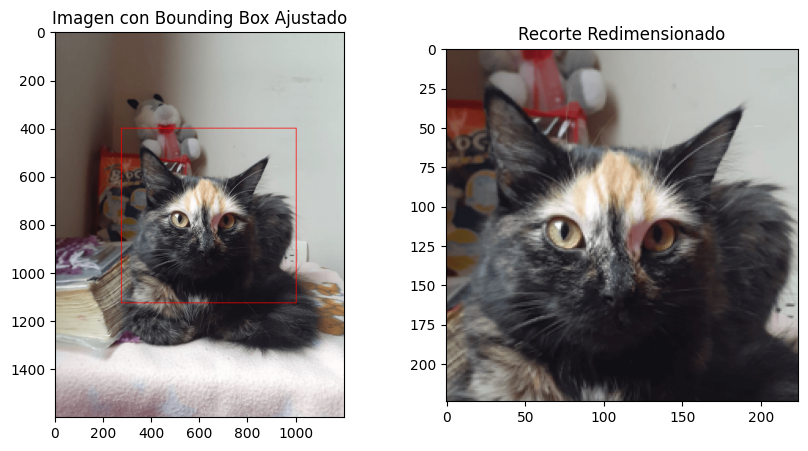

In [1]:
import os
import torch
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from PIL import ImageDraw
import os
import json
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

# Definición de la clase del modelo
class DenseNet121BoundingBox(nn.Module):
    def __init__(self):
        super(DenseNet121BoundingBox, self).__init__()
        self.backbone = models.densenet121(pretrained=True)
        self.backbone.classifier = nn.Identity()  # Eliminar la capa fully connected original
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)  # 4 coordenadas para las esquinas de la caja
        
    def forward(self, x):
        x = self.backbone(x)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)  # La salida es un vector con 4 coordenadas
        return x

# Crear el modelo y cargar los pesos
model = DenseNet121BoundingBox().cuda()
model.load_state_dict(torch.load('FaceDetector V3.pth'))
model.eval()  # Cambiar a modo de evaluación

def adjust_bbox_to_original(pred_bbox, original_size, target_size=(224, 224)):
    """Ajusta el bounding box predicho en el tamaño redimensionado (224x224) a las coordenadas originales."""
    original_width, original_height = original_size
    target_width, target_height = target_size
    
    # Calcular factor de escala
    scale_x = original_width / target_width
    scale_y = original_height / target_height
    
    # Aplicar el factor de escala al bounding box
    x_min, y_min, x_max, y_max = pred_bbox
    x_min = int(x_min * scale_x)
    y_min = int(y_min * scale_y)
    x_max = int(x_max * scale_x)
    y_max = int(y_max * scale_y)
    
    return [x_min, y_min, x_max, y_max]

def crop_and_resize(image, bounding_box, target_size=(224, 224)):
    """Recorta la imagen usando el bounding box ajustado y redimensiona a 224x224."""
    cropped_image = image.crop(bounding_box)
    resized_image = cropped_image.resize(target_size)
    return resized_image

def plot_image_with_bounding_box(image, bounding_box):
    """Dibuja el bounding box sobre la imagen."""
    draw = ImageDraw.Draw(image)
    draw.rectangle(bounding_box, outline="red", width=3)
    return image

def process_image_without_labels(model, image_path, output_dir):
    """Procesa una imagen sin etiquetas y guarda el bounding box predicho y el recorte."""
    # Cargar la imagen
    image = Image.open(image_path).convert('RGB')
    original_size = image.size

    # Transformar la imagen para el modelo (224x224)
    transform = A.Compose([
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2(),
    ])
    image_transformed = transform(image=np.array(image))['image'].unsqueeze(0).cuda()  # Añadir batch y mover a GPU

    # Predicción del bounding box
    with torch.no_grad():
        pred_bbox = model(image_transformed).cpu().numpy()[0]

    # Ajustar el bounding box al tamaño original
    adjusted_bbox = adjust_bbox_to_original(pred_bbox, original_size)

    # Dibujar y guardar la imagen con el bounding box
    image_with_bbox = plot_image_with_bounding_box(image.copy(), adjusted_bbox)
    image_with_bbox_path = os.path.join(output_dir, f"bbox_{os.path.basename(image_path)}")
    image_with_bbox.save(image_with_bbox_path)

    # Recortar y redimensionar la imagen
    cropped_image = crop_and_resize(image, adjusted_bbox)
    cropped_image_path = os.path.join(output_dir, f"cropped_{os.path.basename(image_path)}")
    cropped_image.save(cropped_image_path)

    # Mostrar la imagen con el bounding box y el recorte
    plt.figure(figsize=(10, 5))
    
    # Imagen con bounding box
    plt.subplot(1, 2, 1)
    plt.imshow(image_with_bbox)
    plt.title('Imagen con Bounding Box Ajustado')
    plt.axis('on')

    # Imagen recortada
    plt.subplot(1, 2, 2)
    plt.imshow(cropped_image)
    plt.title('Recorte Redimensionado')
    plt.axis('on')

    plt.show()

# Uso de la función
muestra_path = os.path.join("..", "cropped_images")
# Path to the image to test
image_path = os.path.join(muestra_path, "muestra.png")
#image_path = r'C:\CatFLW dataset\cropped_images\muestra.png'  # Cambia por el nombre de tu imagen
output_dir = muestra_path  # Directorio de salida para guardar los recortes
process_image_without_labels(model, image_path, output_dir)
